In [1]:
#
# This section taken from MaterialsAutomated0-CurieWeiss
#
import logging
import csv

# Section aware importer of a PPMS data file
def readPPMSDataFile(file):
    rv = {}
    with open(file, newline="") as f:
        r = csv.reader(f,delimiter=',')
        hdr = []
        data = []
        section = None
        for l in r:
            if len(l) > 0:
                if l[0].lower() == '[Header]'.lower():
                    section = hdr
                elif l[0].lower() == '[Data]'.lower():
                    section = data
                elif len(l[0]) > 0 and l[0][0] == ';':
                    pass # ignore commented out lines
                elif section != None:
                    section.append(l)
                else:
                    logging.warning("No section yet defined for line: %s", l)
            else:
                logging.info("Ignoring empty line: %s", l)
        rv['header'] = hdr
        rv['data'] = data
    return rv

# Get the names of all the header variables
def getHeaders(fileData):
    rv = None
    if 'header' in fileData:
        rv = []
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            rv.append(l[0])
    return rv
   
# Get the value of a named header variable
def getHeaderValue(fileData, name):
    rv = None
    if 'header' in fileData:
        for l in fileData['header']:
            # no need to check len(l) > 0 since our file reader already dealt with that
            if l[0].lower() == name.lower():
                if len(l) > 1:
                    val = ''.join(l[1:])
                else:
                    val = ''
                if rv is None:
                    rv = []
                rv.append(val)
    if (len(rv) > 1):
        return rv
    return rv[0]

# Get the names of the available data columns
def getDataColumns(fileData):
    rv = None
    if 'data' in fileData and len(fileData['data']) > 0:
        rv = fileData['data'][0]
    return rv

# Get the entries stored in one data column
def getDataColumn(fileData, name, prefixMatching=True):
    rv = None
    if 'data' in fileData:
        headers = None
        nameIndex = None
        headerName = None
        for l in fileData['data']:
            if headers is None:
                headers = l
                for i,h in enumerate(headers):
                    if ((prefixMatching and len(h) >= len(name) and h[0:len(name)].lower() == name.lower()) or
                       (not prefixMatching and h.lower() == name.lower())):
                        if nameIndex is None:
                            nameIndex = i
                            headerName = h
                            rv = []
                        else:
                            logging.warning("Ambiguous column selected: %s and %s both match %s", headerName, h, name)
            elif nameIndex != None:
                if len(l) > nameIndex:
                    try:
                        rv.append(float(l[nameIndex]))
                    except ValueError:
                        rv.append(l[nameIndex])
                else:
                    rv.append(None)
                    logging.warning("Unusually short line in data section: %s", l)
    return rv

In [2]:
import numpy as np
from math import sqrt
#
# Often time specific heat data is collected in duplicate. This function
# takes as input temp, cp, and optionally cp_err columns and outputs
# a condensed/averaged dataset with proper propagation of error
# (assuming independent random errors, and with a minor sin regarding
# combining the sample std dev estimator with the individual point std dev's)
#
# temp_tol is the % temperature difference within with different measurements are considered to be "the same"
# set to 1%, a typical semi-adiabatic temperature rise
#
def mergeCp(temp,cp,cp_err=None,temp_tol=0.01):
    if cp_err is None:
        cp_err = np.ones(cp.shape)
    rv = []
    lT = temp[0]
    lCp = cp[0]
    lCpss = 0
    lCpe = cp_err[0]*cp_err[0]
    lnum = 1
    for i in range(1,len(temp)):
        if (temp[i]-lT)/lT < temp_tol:
            # same temperature, merge
            # compute running averages, etc, with Welford's algorithm
            lnum += 1
            lT = lT + (temp[i]-lT)/lnum
            # must compute sum squares update before updating mean
            lCpnew = lCp + (cp[i]-lCp)/lnum
            lCpss = lCpss + (cp[i]-lCp)*(cp[i]-lCpnew)
            lCp = lCpnew
            lCpe += cp_err[i]*cp_err[i]
        else:
            # new temperature, no merge
            rv.append([lT,lCp,sqrt((lCpss+lCpe)/lnum)])
            lT = temp[i]
            lCp = cp[i]
            lCpss = 0
            lCpe = cp_err[i]*cp_err[i]
            lnum = 1
    # wrap up last one
    rv.append([lT,lCp,sqrt((lCpss+lCpe)/lnum)])
    return np.transpose(np.array(rv))

In [3]:
import numpy as np

# Read Sample input data
#
# If some lines are malformed, some warnings will occur. You must check to ensure the
# warnings are inert.
#
# Could adopt the same techniques as in MaterialsAutomated0-CurieWeiss to automatically
# segment into submeasurements as appropriate (good first issue)
#
curFile = readPPMSDataFile("input.dat")
temp = getDataColumn(curFile,"Sample Temp (Kelvin)")
cp = getDataColumn(curFile,"Samp HC (")
cpe = getDataColumn(curFile,"Samp HC Err")

# Remove rows with no values, assign temp and cp for later use
xye = np.array([temp,cp,cpe],dtype=np.float64)
xye = xye[:,~(np.isnan(xye).any(axis=0))]
# merge "same" measurements
xye = mergeCp(xye[0],xye[1],xye[2])
temp = xye[0]
cp = xye[1]
cpe = xye[2]


In [4]:
import scipy.integrate
import scipy.interpolate
import scipy.constants
#
# from Tari, Specific Heat of Matter at Low Tmperatures
#
def einstein(T, T_E):
    R = scipy.constants.gas_constant # J/mol-K
    return 3*R*(T_E/T)**2 * np.exp(-(T_E/T))/(1.0-np.exp(-(T_E/T)))**2

def debyeIntegralSlow(r):
    return scipy.integrate.quad(lambda x: x**4*np.exp(-x)/(1.0-np.exp(-x))**2, 0, r)[0]

#
# The debye integral function is very slow, it can be sped up by using appropriate interpolation
#
rtmp = np.array(range(0,2000))/100+0.005
rtmpy = []
for a in rtmp:
    rtmpy.append([a,debyeIntegralSlow(a)])
rtmpy = np.vstack([np.array([0.0,0.0]),rtmpy,np.array([np.inf, debyeIntegralSlow(50)])])
debyeIntegral = scipy.interpolate.interp1d(rtmpy[:,0],rtmpy[:,1])

def debye(T, T_D):
    R = scipy.constants.gas_constant # J/mol-K
    return 9*R*(T/T_D)**3*np.vectorize(debyeIntegral)(T_D/T)

In [5]:
#
# Here we define a couple common combinations of simple phonon contributions to fit data overall
#
def combinedDebyeEinstein(temp,sD,TD,sE,TE):
    # returns C
    return (sD*debye(temp,TD)+sE*einstein(temp,TE))

def combined2DebyeEinstein(temp,sD1,TD1,sD2,TD2,sE,TE):
    # returns C
    return (sD1*debye(temp,TD1)+sD2*debye(temp,TD2)+sE*einstein(temp,TE))

def combinedGamma2DebyeEinstein(temp,gamma,sD1,TD1,sD2,TD2,sE,TE):
    # returns C
    return gamma*temp+(sD1*debye(temp,TD1)+sD2*debye(temp,TD2)+sE*einstein(temp,TE))


In [6]:
import scipy.optimize

# 
# In order to make sure all components are adequately considered, it is often
# important to simultaneously fit C, C/T, C/T^2, C/T^3 to a single unified
# model. Care must be taken to appropriately weight each dataset similarly.
# This is done by appropriately dividing the sigmas by temp^power and passing
# as well.
#
# The final component is to turn the multidimensional fit into a pseudo-1D
# one using ravel to flatten the arrays.
#
# This example uses the 2Debye + Einstein
#

def fitFunc(temp,sD1,TD1,sD2,TD2,sE,TE):
    c = combined2DebyeEinstein(temp,sD1,TD1,sD2,TD2,sE,TE)
    return np.stack([c,c/temp,c/temp**2,c/temp**3]).ravel()

cpfit = np.stack([cp,cp/temp,cp/temp**2,cp/temp**3]).ravel()
cpefit = np.stack([cpe,cpe/temp,cpe/temp**2,cpe/temp**3]).ravel()
# if the HC errors are not available, can generate ficticious errors that are appropriately scaled by temp
# and pass as sigma
#cpefit = np.stack([1/np.ones(temp.shape),1/temp,1/temp**2,1/temp**3])/100.0
fit = scipy.optimize.curve_fit(fitFunc,temp,cpfit,sigma=cpefit,p0=[4,300,6,800,1,100],bounds=(0.0,np.inf), absolute_sigma=True)

<IPython.core.display.Javascript object>


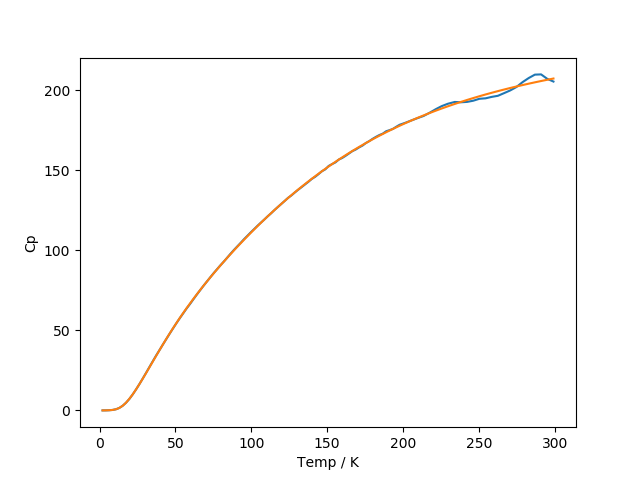

<IPython.core.display.Javascript object>


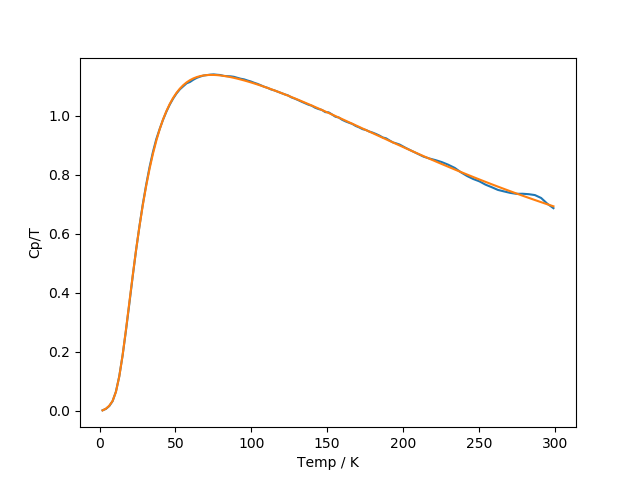

<IPython.core.display.Javascript object>


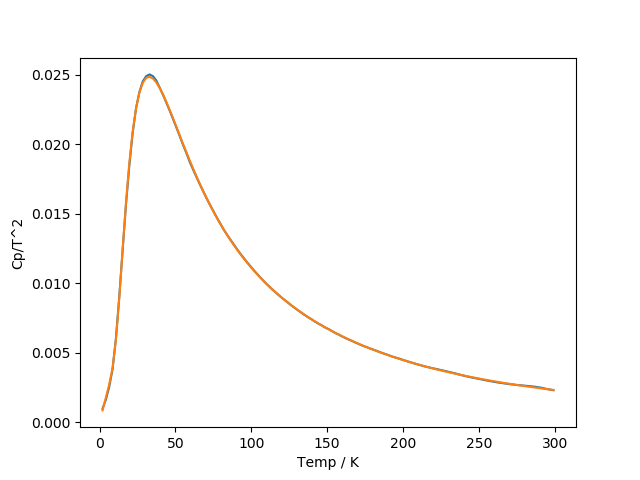

<IPython.core.display.Javascript object>


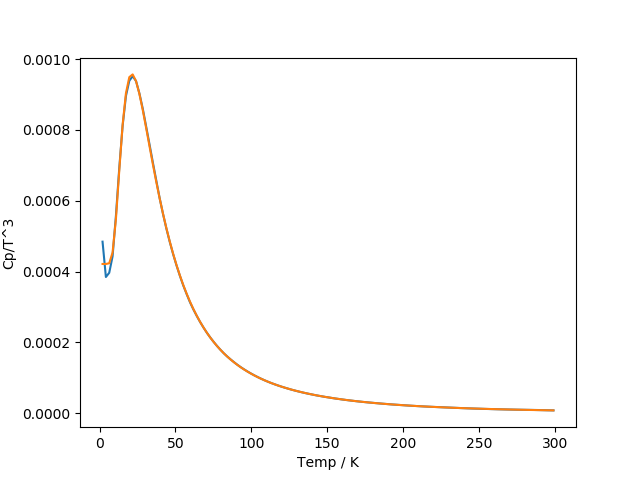

[  3.11987087 249.45157689   5.29322398 694.30072007   1.20591222
 105.94592133]
errors
[0.06062004 1.53329016 0.03954    7.73125715 0.01189765 0.32995856]


In [7]:
#
# Sanity plots
#
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("Temp / K")
plt.ylabel("Cp")
plt.plot(temp,np.transpose([cp,combined2DebyeEinstein(temp,*fit[0])]))
plt.figure()
plt.xlabel("Temp / K")
plt.ylabel("Cp/T")
plt.plot(temp,np.transpose([cp/temp,combined2DebyeEinstein(temp,*fit[0])/temp]))
plt.figure()
plt.xlabel("Temp / K")
plt.ylabel("Cp/T^2")
plt.plot(temp,np.transpose([cp/temp**2,combined2DebyeEinstein(temp,*fit[0])/temp**2]))
plt.figure()
plt.xlabel("Temp / K")
plt.ylabel("Cp/T^3")
plt.plot(temp,np.transpose([cp/temp**3,combined2DebyeEinstein(temp,*fit[0])/temp**3]))
# Print parameters
print(fit[0])
print("errors")
print(np.sqrt(np.diag(fit[1])))

<IPython.core.display.Javascript object>


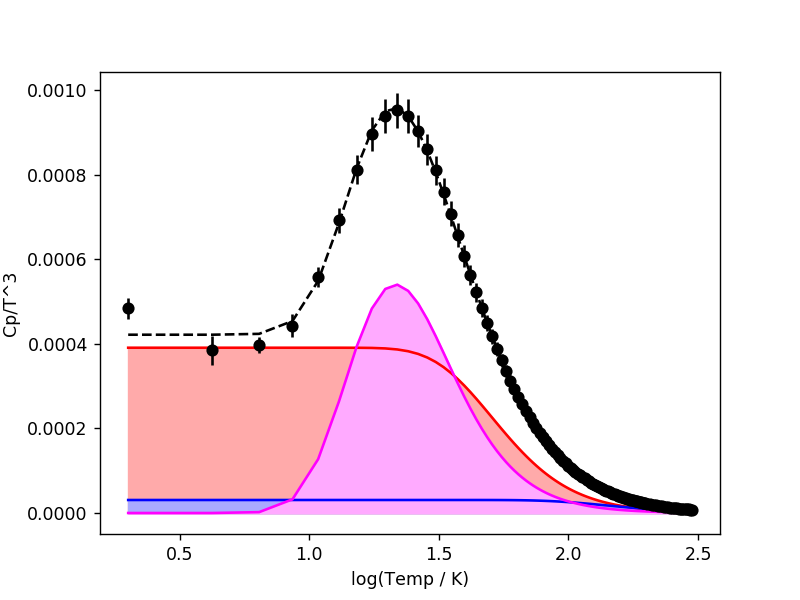

In [8]:
#
# An Einstein money plot
#
%matplotlib notebook
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel("log(Temp / K)")
plt.ylabel("Cp/T^3")
plt.errorbar(np.log10(temp),cp/temp**3,yerr=3*cpe/temp**3,fmt="ko") # 3-sigma error bars
# The below change according to which function you are fitting of course.
plt.plot(np.log10(temp),combined2DebyeEinstein(temp,*fit[0])/temp**3,"k--")
plt.plot(np.log10(temp),fit[0][0]*debye(temp,fit[0][1])/temp**3,color="#ff0000")
plt.fill_between(np.log10(temp),fit[0][0]*debye(temp,fit[0][1])/temp**3,color="#ffaaaa")
plt.plot(np.log10(temp),fit[0][2]*debye(temp,fit[0][3])/temp**3,color="#0000ff")
plt.fill_between(np.log10(temp),fit[0][2]*debye(temp,fit[0][3])/temp**3,color="#aaaaff")
plt.plot(np.log10(temp),fit[0][4]*einstein(temp,fit[0][5])/temp**3,color="#ff00ff")
plt.fill_between(np.log10(temp),fit[0][4]*einstein(temp,fit[0][5])/temp**3,color="#ffaaff")
